In [ ]:
import sys
!{sys.executable} -m pip install --upgrade numpy==1.21
import numpy as np
np.__version__

In [ ]:
import numpy as np
np.__version__

In [867]:
import torch
import os
import numpy as np
from os import walk
import torchvision
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from torchvision.io import read_image
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchsummary import summary
from scipy.spatial import distance
from annoy import AnnoyIndex
import pickle 
import gc
import random
from sklearn import preprocessing
import torch.nn.functional as F
from statistics import mean
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from IPython.display import clear_output
import tensorflow as tf
import tensorflow_hub as hub
import copy
from collections import Counter

# Preprocessing, embedding and search

## Transform class

In [ ]:
class Transform:
    def __init__(self, out_c = 3, normalize=False, mean=None, std=None):
        if normalize:
            self.transformer = transforms.Compose([transforms.Resize((256,256)),
                                               transforms.Grayscale(num_output_channels=out_c),
                                               transforms.ToTensor(), 
                                               transforms.Normalize(mean, std)])
        else:
            self.transformer = transforms.Compose([transforms.Resize((256,256)),
                                               transforms.Grayscale(num_output_channels=out_c),
                                               transforms.ToTensor()])

## Dataset class

In [ ]:
class Dataset:
    
    def __init__(self, folder_path, transform = None, convolve = False, c=3, ex=False):
        self.folder_path = folder_path
        self.names = [name for name in os.listdir(folder_path) if name != ".DS_Store"]
        self.transform = transform
        self.convolve = convolve
        self.c = c
        self.ex = ex
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        if self.ex:
            im_path = "/Users/daanschoppink/Documents-Local/photos_sample/"+self.names[idx]
        else:
            im_path = os.path.join(self.folder_path, self.names[idx])
        image = Image.open(im_path)
        if self.transform:
            image = self.transform(image)
        if self.convolve:
            image = Convolve(self.c).detect_edges(image)
        return image, im_path, image, self.names[idx]

## Model class

In [ ]:
class Model:
    def __init__(self, model_str, input_shape, weights=True):
        self.model_str= model_str
        self.weights = weights
        self.input_shape = input_shape
        self.model = getattr(torchvision.models, model_str)(weights=weights).eval()
        self.model.eval()
        self.extractor_model = None
    
    def summary(self):
        return summary(self.model, tuple(self.input_shape))
    
    def feature_extractor(self, return_key, return_value):
        self.return_key = return_key
        return_nodes = {return_key : return_value}
        # self.model.eval()
        self.extractor_model = create_feature_extractor(self.model, return_nodes=return_nodes).eval()
        # self.extractor_model.eval()
        
    def embed(self, data):
        shape_error = "Error, input data shape doesn't match model input shape {}".format(self.input_shape)
        if isinstance(data, Dataset):
            return ((self.extractor_model(d[0].unsqueeze(0))[self.return_key], d[1], d[2], d[3])\
                    if list(d[0].shape) == self.input_shape else print(shape_error) for d in data)
        else:
            if list(data[0].shape) == self.input_shape:
                return (self.extractor_model(data[0].unsqueeze(0))[self.return_key], data[1], data[2], data[3])
            else:
                print(shape_error)        

## Tree class

In [ ]:
class Tree():
    def __init__(self, f, metric):
        self.tree = AnnoyIndex(f, metric)
        self.metric = metric
        self.f = f
        self.idx_image = {}
        
    def transformTensor(self, tensor):
        return tensor.squeeze(0).detach().numpy().flatten()
    
    def indexData(self, d, i):
        self.idx_image[i] = d

    def buildTree(self, embeddings, name, n_trees = 10):
        self.tree.on_disk_build("/Users/daanschoppink/Documents/UvA/Thesis_Master/trees/"+name+"_tree.ann")
        for data in embeddings:
            for i, d in enumerate(data):
                
                self.tree.add_item(i, d[0])
                self.idx_image[i] = (d[1], d[2], d[3])
                
                del d
        self.tree.build(n_trees)
        # self.tree.save("/Users/daanschoppink/Documents/UvA/Thesis_Master/trees/"+name+"_tree.ann")

        with open("/Users/daanschoppink/Documents/UvA/Thesis_Master/indexes/"+name +'_idx.pkl', 'wb') as o:
            pickle.dump(self.idx_image, o)
      
    def search(self, v, n, return_type="index", return_distance = False, search_k=-1 ):
        if return_type=='index':
            return self.tree.get_nns_by_vector(v, n, search_k=-1, include_distances=return_distance)
        elif return_type=='image':
            indexes = self.tree.get_nns_by_vector(v, n, search_k=-1, include_distances=return_distance)
            # print(indexes)
            if return_distance:
                return [(torchvision.transforms.Resize((256, 256))(Image.open(self.idx_image[i][0])), transforms.ToPILImage()(self.idx_image[i][1]), self.idx_image[i][2], d) for i, d in zip(indexes[0],indexes[1])]
            else:
                return [(torchvision.transforms.Resize((256, 256))(Image.open(self.idx_image[i][0])), transforms.ToPILImage()(self.idx_image[i][1]), self.idx_image[i][2]) for i in indexes]
        
        

# Domain Adaptation

## Edge detecting

In [ ]:
'''
Edge decting by gaussian blurring an image
and convolving it with sobel kernels
'''
class Convolve():
    def __init__(self, k, s=None):
        self.k = k
        self.s = s
        
    def sobel_kernel(self):
        vertical = torch.tensor([[[[1.,2.,1.], 
                                   [0.,0.,0.], 
                                   [-1.,-2.,-1.]]]])
        
        horizontal = torch.tensor([[[[-1.,0,1.], 
                                     [-2.,0.,2.],
                                     [-1.,0,1.]]]])
        return vertical, horizontal
    
    def blur(self, img):
         if self.s == None:
            return transforms.GaussianBlur(kernel_size = self.k)(img)
         else:
            return transforms.GaussianBlur(kernel_size = self.k, sigma = self.s)(img)

    def detect_edges(self, img):
        img = self.blur(img)
        v, h = self.sobel_kernel()
        img_v = F.conv2d(img,v)
        img_h = F.conv2d(img, h)
        
        img = np.sqrt(pow(img_v, 2.0) + pow(img_h, 2.0))
        img = img.expand(3, -1, -1)
        img = transforms.Resize((256,256))(img)
        return img

## Neural style transfer

In [ ]:
'''
Source: https://www.tensorflow.org/tutorials/generative/style_transfer
'''
class NTransfer():
    def __init__(self, folder_path, model=None):
        self.folder_path = folder_path
        self.names = [name for name in os.listdir(folder_path) if name != ".DS_Store"]
        if model != None:
            self.model = hub.load(model)
        os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        im_path = os.path.join(self.folder_path, self.names[idx])
        img = tf.io.read_file(im_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)

        img = tf.image.resize(img, (256,256))
        img = img[tf.newaxis, :]

        return img, self.names[idx]
        
    def stylize(self, path, style_imgs):
        if len(style_imgs) > 1:
            for img, style in zip(self, style_imgs):
                self.save_image(self.model(tf.constant(img[0]), tf.constant(style[0]))[0], path, img[1])
        else:
            for img in self:
                self.save_image(self.model(tf.constant(img[0]), tf.constant(style_imgs[0][0]))[0], path, img[1])

    def save_image(self, tensor, path, name):
        tensor = tensor*255
        tensor = np.array(tensor, dtype=np.uint8)
        
        if np.ndim(tensor)>3:
            assert tensor.shape[0] == 1
        tensor = tensor[0]
        img = Image.fromarray(tensor)
        img.save(path+'/'+name)
        img.close
    

## Support functions

In [ ]:
'''
Source: https://stackoverflow.com/questions/37921295/python-pil-image-make-3x3-grid-from-sequence-images
'''
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
def mean_vgg16(A):
    B = np.zeros(512)
    A = A.squeeze(0)
    for i, a in enumerate(A):
        B[i] = torch.mean(a).detach().numpy()
    return B

In [ ]:
def save_image(tensor, path, name):
        tensor = tensor*255
        tensor = np.array(tensor, dtype=np.uint8)
        
        if np.ndim(tensor)>3:
            assert tensor.shape[0] == 1
        tensor = tensor[0]
        img = Image.fromarray(tensor)
        img.save(path+'/'+name)
        img.close

# Building datasets

In [941]:
'''
Comics and photos paths
'''
photos_path = "/data/photos_testset"
comics_path = "/data/comics_testset"
pc_path = "/data/posters_covers_testset"
comics_sample_path = "/data/Documents-Local/comics_sample"


# Where 0.0 is the subfolder with alpha level 0.0
adain_path_0 = "/data/stylized_photo_AdaIN_testset/0.0"
adain_path_2 = "/data/stylized_photo_AdaIN_testset/0.2"
adain_path_4 = "/data/stylized_photo_AdaIN_testset/0.4"
adain_path_6 = "/data/stylized_photo_AdaIN_testset/0.6"
adain_path_8 = "/data/stylized_photo_AdaIN_testset/0.8"
adain_path_1 = "/data/stylized_photo_AdaIN_testset/1.0"

# Adain stylization with alpha 1.0 applied to the testset with 1000 extra photos as noise
adain_noise_path_E = "/data/adain_noise/EfficientNetV2/"
adain_noise_path_R = "/data/adain_noise/ResNet/"

adain_no_noise_path_E = "/data/adain_no_noise/EfficientNetV2/"
adain_no_noise_path_R = "/data/adain_no_noise/ResNet/"

adain_sample_path = "/data/Documents-Local/adain_sample"

# Path to folder containing the styles for Gatys algorithm
styles_path = "/data/styles"
stylized_photo_path = "/data/stylized_photo_testset"

# Path to folder containing the convolved photos, 33 being the subfolder for 33 gaussian blur kernel
convolved_path_3 = "/data/convoled_photo_testset/3"
convolved_path_9 = "/data/convoled_photo_testset/9"
convolved_path_15 = "/data/convoled_photo_testset/15"
convolved_path_21 = "/data/convoled_photo_testset/21"
convolved_path_27 = "/data/convoled_photo_testset/27"
convolved_path_33 = "/data/convoled_photo_testset/33"

In [ ]:
''' Gatys model as provided by tensorflow'''
hub_model = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
imgs = NTransfer(photos_path, hub_model)
styles = NTransfer(comics_path)

In [ ]:
styles = [s for s in styles]
styles.append(styles[21])

In [ ]:
names = [(i,x[1]) for i,x in enumerate(styles)]
names

In [ ]:
# Stylization of the photos testset saved to a folder
imgs.stylize(stylized_photo_path, [styles[11]])

### Buidling edge detected image folders

In [ ]:
# Edge detecting the photo testset, saving it to a folder with c applied blur
t2 = Transform(1, False, _mean, _std).transformer
photos_conv_t2 = Dataset(photos_path t2, True, c=33)

path = "/data/convoled_photo_testset/33"
for c in photos_conv_t2:
    save_image(c[0], path, c[3])

### Creating datasets

In [942]:
# mean and std when normalizing images
_mean = (0.485, 0.456, 0.406)
_std = (0.229, 0.224, 0.225)

# Tranformer withoutout convolution, 3 channel image
t = Transform(3, True, _mean, _std).transformer

# Tranformer with convolution, 1 channel image


# Regular dataset
photos = Dataset(photos_path, t)
comics = Dataset(comics_path, t)
pcs = Dataset(pc_path, t)
comics_sample = Dataset(comics_sample_path, t)

# Gatys stylized dataset
photos_stylized = Dataset(stylized_photo_path, t)

# Adain stylized dataset
photos_adain_0 = Dataset(adain_path_0, t)
photos_adain_2 = Dataset(adain_path_2, t) 
photos_adain_4 = Dataset(adain_path_4, t) 
photos_adain_6 = Dataset(adain_path_6, t) 
photos_adain_8 = Dataset(adain_path_8, t) 
photos_adain_1 = Dataset(adain_path_1, t) 

photos_adain_noise_R = Dataset(adain_noise_path_R, t)
photos_adain_noise_E = Dataset(adain_noise_path_E, t)
photos_adain_no_noise_R = Dataset(adain_no_noise_path_R, t)
photos_adain_no_noise_E = Dataset(adain_no_noise_path_E, t) 
photos_adain_sample = Dataset(adain_sample_path, t, ex=True)

# Convolved dataset being the amount of gaussian blur
photos_conv_3 = Dataset(convolved_path_3, t)
photos_conv_9 = Dataset(convolved_path_9, t)
photos_conv_15 = Dataset(convolved_path_15, t)
photos_conv_21 = Dataset(convolved_path_21, t)
photos_conv_27 = Dataset(convolved_path_27, t)
photos_conv_33 = Dataset(convolved_path_33, t)

### Building the ANN trees

In [955]:
def buildTree(photos, pcs, sep):
    # models = [('resnet18', 512, 'ResNet18'), ('vgg16', 512, 'VGG16'), 
     #     ('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]
    # dm = ["angular", "euclidean", "manhattan", "hamming",  "dot"]

    models = [('resnet18', 512, 'ResNet18'),('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]
    # models = [ ('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]
    dm = ["manhattan"]

    for m in models:
        w = m[2]+'_Weights.DEFAULT'
        model = Model(m[0], [3, 256, 256], weights=w)
        model.feature_extractor('avgpool', 'avgpool')

        photos_embedded = model.embed(photos)
        pcs_embedded = model.embed(pcs)

        if m[0] != 'vgg16':
            photos_embedded_flat = [(photo[0].squeeze(0).detach().numpy().flatten(), photo[1], photo[2], photo[3]) for photo in photos_embedded]
            pcs_embedded_flat = [(pc[0].squeeze(0).detach().numpy().flatten(), pc[1], pc[2], pc[3]) for pc in pcs_embedded]
        else:
            photos_embedded_flat = [(mean_vgg16(photo[0]), photo[1], photo[2], photo[3]) for photo in photos_embedded]
            pcs_embedded_flat = [(mean_vgg16(pc[0]), pc[1], pc[2], pc[3]) for pc in pcs_embedded]
        
        for d in dm:
            if d == 'dot':
                photos_embedded_flat = [(preprocessing.normalize([photo[0]], norm='l2').flatten(), photo[1], photo[2], photo[3]) for photo in photos_embedded_flat]
                pcs_embedded_flat = [(preprocessing.normalize([pc[0]], norm='l2').flatten(), pc[1], pc[2], pc[3]) for pc in pcs_embedded_flat]
            tree = Tree(m[1], d)
            tree.buildTree([photos_embedded_flat + pcs_embedded_flat], m[0]+sep+d)

In [945]:
%%time
a = '0.8'
# g = '33'
# Build a regular tree
buildTree(photos, pcs, '_')

# Build Gatys style transfered tree
buildTree(photos_stylized, pcs, '_stylized_')


# buildTree(photos_adain_sample, pcs, '_stylized_adain_sample_'+a+'_')

CPU times: user 1min 28s, sys: 19.5 s, total: 1min 48s
Wall time: 1min 33s


In [888]:
buildTree(photos_adain_noise_E, pcs, '_stylized_adain_noise_E_')

In [892]:
buildTree(photos_adain_noise_R, pcs, '_stylized_adain_noise_R_')

In [890]:
buildTree(photos_adain_no_noise_E, pcs, '_stylized_adain_no_noise_E_')

In [893]:
buildTree(photos_adain_no_noise_R, pcs, '_stylized_adain_no_noise_R_')

In [ ]:
buildTree(photos_adain_sample, pcs, '_stylized_adain_sample_')

In [956]:
# Build Adain trees
buildTree(photos_adain_0, pcs, '_stylized_adain_0.0_')
buildTree(photos_adain_2, pcs, '_stylized_adain_0.2_')
buildTree(photos_adain_4, pcs, '_stylized_adain_0.4_')
buildTree(photos_adain_6, pcs, '_stylized_adain_0.6_')
buildTree(photos_adain_8, pcs, '_stylized_adain_0.8_')
buildTree(photos_adain_1, pcs, '_stylized_adain_1.0_')

In [ ]:
%%time
# Build edge detected tree
buildTree(photos_conv_3, pcs, '_conv_3_')
buildTree(photos_conv_9, pcs, '_conv_9_')
buildTree(photos_conv_15, pcs, '_conv_15_')
buildTree(photos_conv_21, pcs, '_conv_21_')
buildTree(photos_conv_27, pcs, '_conv_27_')
buildTree(photos_conv_33, pcs, '_conv_33_')

# Searching the trees

## Matches

In [ ]:
matches = pd.read_csv("/data/matches.csv", sep=';', index_col='comic')
matches['correct'] = matches.values.tolist()
matches = matches.groupby('comic')['correct'].apply(sum)
matches = matches.to_frame()
for i in matches.index:
    matches.loc[i, 'correct'] = [x for x in matches.loc[i, 'correct'] if str(x) != 'nan']

In [850]:
matches

,correct
comic,
comic_1.jpg,[photo_1.jpg]
comic_10.jpg,[photo_11.jpg]
comic_11.jpg,[photo_12.jpg]
comic_12.jpg,[photo_13.jpg]
comic_13.jpg,[pc_15.jpg]
comic_14.jpg,[photo_14.jpg]
comic_15.jpg,[photo_14.jpg]
comic_16.jpg,[pc_12.jpg]
comic_17.jpg,[pc_13.jpg]


## Evaluation

In [ ]:
trees_path = "/data/trees/"
indexes_path = "/data/indexes/"

In [ ]:
def create_results(models, metrics, comics, n, tree_path, index_path, sep, expert = False):
    results = {}
    for mod in models:
        w = mod[2]+'_Weights.DEFAULT'
        model = Model(mod[0], [3, 256, 256], weights=w)
        model.feature_extractor('avgpool', 'avgpool')
        results[mod[0]] = {}
        if mod[0] != 'vgg16':
            comics_embedded = model.embed(comics)
            comics_embedded_flat = [(comic[0].squeeze(0).detach().numpy().flatten(), 
                                     comic[1], comic[2], comic[3]) for comic in comics_embedded]
        else:
            comics_embedded = model.embed(comics)
            comics_embedded_flat = [(mean_vgg16(comic[0]), 
                                     comic[1], comic[2], comic[3]) for comic in comics_embedded]
        for m in metrics:
            results[mod[0]][m] = {}
            mod_tree = Tree(mod[1], m)
            mod_tree.tree.load(tree_path+mod[0]+sep+m+'_tree.ann')

            with open(index_path+mod[0]+sep+m+'_idx.pkl', "rb") as o:
                mod_tree.idx_image = pickle.load(o)

            for comic in comics_embedded_flat:
                img = mod_tree.search(comic[0], n, 'image', False)
                res = [v[2] for v in img]
                
                if not expert:
                    results[mod[0]][m][comic[3]] = res
                else:
                    results[mod[0]][m][comic[3]] = (img, res, 
                                                    torchvision.transforms.Resize((256, 256))(Image.open(comic[1])))
                    
            
    return results

def AP(Q, G):
    GTP = len(Q)
    predicted = 0
    positive = 0
    ap = 0

    for g in G:
        predicted += 1
        if g in Q:
            positive += 1
            ap += positive / predicted
        
        if positive == GTP:
            break

    return (1/GTP) * ap

def calculate_model_accuracy(results, matches):
    model_perf, model_counts = {}, {}
    model_perf['accuracy'], model_perf['recall'], model_perf['map'] = {}, {}, {}
    for model in results.keys():
        model_perf['accuracy'][model], model_perf['recall'][model], model_counts[model], model_perf['map'][model] = {}, {}, {}, {}
        for metric in results[model].keys():
            correct_count, pc, ph, ap = 0,0,0,0
            for v in results[model][metric]:

                ap += AP(matches.loc[v, 'correct'], results[model][metric][v])
                
                correct = [i for i in results[model][metric][v] if i in matches.loc[v, 'correct']]
                if correct != []:
                    correct_count += 1
                
                pc += sum((itm.count("pc") for itm in correct))
                ph += sum((itm.count("photo") for itm in correct))
                
            model_perf['accuracy'][model][metric] = correct_count/len(results[model][metric].keys())
            model_perf['recall'][model][metric] = {'pc': pc/10, 'photo' : ph/36}
            model_perf['map'][model][metric] = ap/len(results[model][metric].keys())

    return model_perf

In [946]:
models = [('resnet18', 512, 'ResNet18'), ('vgg16', 512, 'VGG16'), 
          ('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]
metrics = ["angular", "euclidean", "manhattan", "hamming",  "dot"]

n = 6
results = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_')

In [947]:
model_res = calculate_model_accuracy(results, matches)

In [948]:
model_res

{'accuracy': {'resnet18': {'angular': 0.3055555555555556,
   'euclidean': 0.3333333333333333,
   'manhattan': 0.4166666666666667,
   'hamming': 0.3055555555555556,
   'dot': 0.3055555555555556},
  'vgg16': {'angular': 0.2777777777777778,
   'euclidean': 0.3333333333333333,
   'manhattan': 0.3055555555555556,
   'hamming': 0.3055555555555556,
   'dot': 0.2777777777777778},
  'efficientnet_v2_s': {'angular': 0.2222222222222222,
   'euclidean': 0.2777777777777778,
   'manhattan': 0.2222222222222222,
   'hamming': 0.19444444444444445,
   'dot': 0.2222222222222222}},
 'recall': {'resnet18': {'angular': {'pc': 0.5, 'photo': 0.16666666666666666},
   'euclidean': {'pc': 0.5, 'photo': 0.19444444444444445},
   'manhattan': {'pc': 0.5, 'photo': 0.3055555555555556},
   'hamming': {'pc': 0.5, 'photo': 0.16666666666666666},
   'dot': {'pc': 0.5, 'photo': 0.16666666666666666}},
  'vgg16': {'angular': {'pc': 0.5, 'photo': 0.1388888888888889},
   'euclidean': {'pc': 0.3, 'photo': 0.25},
   'manhattan':

In [ ]:
models = [('resnet18', 512, 'ResNet18'), 
          ('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]
metrics = ["manhattan"]

n=6
gatys_results = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_stylized_')

In [ ]:
model_gatys_res = calculate_model_accuracy(gatys_results, matches)

In [ ]:
model_gatys_res

### Edge detected gaussian blur evaluation

In [ ]:
models = [('resnet18', 512, 'ResNet18'), 
          ('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]
metrics = ["manhattan"]

n=6

conv_results3 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_conv_3_')
conv_results9 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_conv_9_')
conv_results15 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_conv_15_')
conv_results21 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_conv_21_')
conv_results27 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_conv_27_')
conv_results33 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_conv_33_')

In [ ]:
model_res_conv3 = calculate_model_accuracy(conv_results3, matches)
model_res_conv9 = calculate_model_accuracy(conv_results9, matches)
model_res_conv15 = calculate_model_accuracy(conv_results15, matches)
model_res_conv21 = calculate_model_accuracy(conv_results21, matches)
model_res_conv27 = calculate_model_accuracy(conv_results27, matches)
model_res_conv33 = calculate_model_accuracy(conv_results33, matches)

In [ ]:
model_res_conv33

### Stylization level evaluation

In [957]:
models = [('resnet18', 512, 'ResNet18'), 
          ('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]
metrics = ["manhattan"]

n=6

adain_res0 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_stylized_adain_0.0_')
adain_res2 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_stylized_adain_0.2_')
adain_res4 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_stylized_adain_0.4_')
adain_res6 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_stylized_adain_0.6_')
adain_res8 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_stylized_adain_0.8_')
adain_res1 = create_results(models, metrics, comics, n, trees_path, indexes_path, sep='_stylized_adain_1.0_')

In [958]:
model_res_adain0 = calculate_model_accuracy(adain_res0, matches)
model_res_adain2 = calculate_model_accuracy(adain_res2, matches)
model_res_adain4 = calculate_model_accuracy(adain_res4, matches)
model_res_adain6 = calculate_model_accuracy(adain_res6, matches)
model_res_adain8 = calculate_model_accuracy(adain_res8, matches)
model_res_adain1 = calculate_model_accuracy(adain_res1, matches)

In [959]:
model_res_adain0

{'accuracy': {'resnet18': {'manhattan': 0.4166666666666667},
  'efficientnet_v2_s': {'manhattan': 0.2222222222222222}},
 'recall': {'resnet18': {'manhattan': {'pc': 0.5,
    'photo': 0.2777777777777778}},
  'efficientnet_v2_s': {'manhattan': {'pc': 0.4,
    'photo': 0.16666666666666666}}},
 'map': {'resnet18': {'manhattan': 0.16219135802469134},
  'efficientnet_v2_s': {'manhattan': 0.1111111111111111}}}

In [960]:
model_res_adain2

{'accuracy': {'resnet18': {'manhattan': 0.3333333333333333},
  'efficientnet_v2_s': {'manhattan': 0.25}},
 'recall': {'resnet18': {'manhattan': {'pc': 0.5,
    'photo': 0.19444444444444445}},
  'efficientnet_v2_s': {'manhattan': {'pc': 0.4,
    'photo': 0.19444444444444445}}},
 'map': {'resnet18': {'manhattan': 0.15300925925925926},
  'efficientnet_v2_s': {'manhattan': 0.11203703703703703}}}

In [961]:
model_res_adain4

{'accuracy': {'resnet18': {'manhattan': 0.3055555555555556},
  'efficientnet_v2_s': {'manhattan': 0.2222222222222222}},
 'recall': {'resnet18': {'manhattan': {'pc': 0.5,
    'photo': 0.16666666666666666}},
  'efficientnet_v2_s': {'manhattan': {'pc': 0.4,
    'photo': 0.1388888888888889}}},
 'map': {'resnet18': {'manhattan': 0.125},
  'efficientnet_v2_s': {'manhattan': 0.09953703703703703}}}

In [962]:
model_res_adain6

{'accuracy': {'resnet18': {'manhattan': 0.3333333333333333},
  'efficientnet_v2_s': {'manhattan': 0.2222222222222222}},
 'recall': {'resnet18': {'manhattan': {'pc': 0.5,
    'photo': 0.19444444444444445}},
  'efficientnet_v2_s': {'manhattan': {'pc': 0.4,
    'photo': 0.1388888888888889}}},
 'map': {'resnet18': {'manhattan': 0.12654320987654322},
  'efficientnet_v2_s': {'manhattan': 0.09722222222222222}}}

In [963]:
model_res_adain8

{'accuracy': {'resnet18': {'manhattan': 0.2777777777777778},
  'efficientnet_v2_s': {'manhattan': 0.19444444444444445}},
 'recall': {'resnet18': {'manhattan': {'pc': 0.5,
    'photo': 0.1388888888888889}},
  'efficientnet_v2_s': {'manhattan': {'pc': 0.4,
    'photo': 0.08333333333333333}}},
 'map': {'resnet18': {'manhattan': 0.11249999999999999},
  'efficientnet_v2_s': {'manhattan': 0.0775462962962963}}}

In [964]:
model_res_adain1

{'accuracy': {'resnet18': {'manhattan': 0.3888888888888889},
  'efficientnet_v2_s': {'manhattan': 0.16666666666666666}},
 'recall': {'resnet18': {'manhattan': {'pc': 0.5, 'photo': 0.25}},
  'efficientnet_v2_s': {'manhattan': {'pc': 0.4,
    'photo': 0.05555555555555555}}},
 'map': {'resnet18': {'manhattan': 0.14050925925925928},
  'efficientnet_v2_s': {'manhattan': 0.06712962962962962}}}

### Scale evaluation

In [929]:
n1 = 6
n2 = 9
n3 = 12
n4 = 15
n5 = 18

# a = 'E'
# models = [('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]

a = 'R'
models = [('resnet18', 512, 'ResNet18')]

metrics = ["angular"]

In [930]:
'''Without noise'''
adain_scale_res1 = create_results(models, metrics, comics, n1, trees_path, indexes_path, sep='_stylized_adain_no_noise_'+a+'_')
adain_scale_res2 = create_results(models, metrics, comics, n2, trees_path, indexes_path, sep='_stylized_adain_no_noise_'+a+'_')
adain_scale_res3 = create_results(models, metrics, comics, n3, trees_path, indexes_path, sep='_stylized_adain_no_noise_'+a+'_')
adain_scale_res4 = create_results(models, metrics, comics, n4, trees_path, indexes_path, sep='_stylized_adain_no_noise_'+a+'_')
adain_scale_res5 = create_results(models, metrics, comics, n5, trees_path, indexes_path, sep='_stylized_adain_no_noise_'+a+'_')

In [931]:
model_scale_res_adain1 = calculate_model_accuracy(adain_scale_res1, matches)
model_scale_res_adain2 = calculate_model_accuracy(adain_scale_res2, matches)
model_scale_res_adain3 = calculate_model_accuracy(adain_scale_res3, matches)
model_scale_res_adain4 = calculate_model_accuracy(adain_scale_res4, matches)
model_scale_res_adain5 = calculate_model_accuracy(adain_scale_res5, matches)

In [932]:
model_scale_res_adain1

{'accuracy': {'resnet18': {'angular': 0.4722222222222222}},
 'recall': {'resnet18': {'angular': {'pc': 0.4, 'photo': 0.3888888888888889}}},
 'map': {'resnet18': {'angular': 0.1986111111111111}}}

In [933]:
model_scale_res_adain2

{'accuracy': {'resnet18': {'angular': 0.5}},
 'recall': {'resnet18': {'angular': {'pc': 0.4, 'photo': 0.4166666666666667}}},
 'map': {'resnet18': {'angular': 0.2020833333333333}}}

In [934]:
model_scale_res_adain3

{'accuracy': {'resnet18': {'angular': 0.6388888888888888}},
 'recall': {'resnet18': {'angular': {'pc': 0.5, 'photo': 0.5277777777777778}}},
 'map': {'resnet18': {'angular': 0.21193181818181817}}}

In [935]:
model_scale_res_adain4

{'accuracy': {'resnet18': {'angular': 0.7222222222222222}},
 'recall': {'resnet18': {'angular': {'pc': 0.5, 'photo': 0.6388888888888888}}},
 'map': {'resnet18': {'angular': 0.2171719484219484}}}

In [936]:
model_scale_res_adain5

{'accuracy': {'resnet18': {'angular': 0.75}},
 'recall': {'resnet18': {'angular': {'pc': 0.5, 'photo': 0.6666666666666666}}},
 'map': {'resnet18': {'angular': 0.21871515829849159}}}

In [920]:
n1 = 6
n2 = 12
n3 = 24
n4 = 48
n5 = 96

# a = 'E'
# models = [('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]

a = 'R'
models = [('resnet18', 512, 'ResNet18')]

metrics = ["angular"]

In [921]:
'''With 1000 noise'''
adain_scale_res_noise1 = create_results(models, metrics, comics, n1, trees_path, indexes_path, sep='_stylized_adain_noise_'+a+'_')
adain_scale_res_noise2 = create_results(models, metrics, comics, n2, trees_path, indexes_path, sep='_stylized_adain_noise_'+a+'_')
adain_scale_res_noise3 = create_results(models, metrics, comics, n3, trees_path, indexes_path, sep='_stylized_adain_noise_'+a+'_')
adain_scale_res_noise4 = create_results(models, metrics, comics, n4, trees_path, indexes_path, sep='_stylized_adain_noise_'+a+'_')
adain_scale_res_noise5 = create_results(models, metrics, comics, n5, trees_path, indexes_path, sep='_stylized_adain_noise_'+a+'_')

In [922]:
model_scale_res_adain_noise1 = calculate_model_accuracy(adain_scale_res_noise1, matches)
model_scale_res_adain_noise2 = calculate_model_accuracy(adain_scale_res_noise2, matches)
model_scale_res_adain_noise3 = calculate_model_accuracy(adain_scale_res_noise3, matches)
model_scale_res_adain_noise4 = calculate_model_accuracy(adain_scale_res_noise4, matches)
model_scale_res_adain_noise5 = calculate_model_accuracy(adain_scale_res_noise5, matches)

In [923]:
model_scale_res_adain_noise1

{'accuracy': {'resnet18': {'angular': 0.1111111111111111}},
 'recall': {'resnet18': {'angular': {'pc': 0.1,
    'photo': 0.08333333333333333}}},
 'map': {'resnet18': {'angular': 0.04282407407407408}}}

In [924]:
model_scale_res_adain_noise2

{'accuracy': {'resnet18': {'angular': 0.1111111111111111}},
 'recall': {'resnet18': {'angular': {'pc': 0.1,
    'photo': 0.08333333333333333}}},
 'map': {'resnet18': {'angular': 0.04282407407407408}}}

In [925]:
model_scale_res_adain_noise3

{'accuracy': {'resnet18': {'angular': 0.19444444444444445}},
 'recall': {'resnet18': {'angular': {'pc': 0.3, 'photo': 0.1111111111111111}}},
 'map': {'resnet18': {'angular': 0.0605489417989418}}}

In [926]:
model_scale_res_adain_noise4

{'accuracy': {'resnet18': {'angular': 0.2222222222222222}},
 'recall': {'resnet18': {'angular': {'pc': 0.4, 'photo': 0.1111111111111111}}},
 'map': {'resnet18': {'angular': 0.06119493663098314}}}

In [927]:
model_scale_res_adain_noise5

{'accuracy': {'resnet18': {'angular': 0.3055555555555556}},
 'recall': {'resnet18': {'angular': {'pc': 0.4,
    'photo': 0.19444444444444445}}},
 'map': {'resnet18': {'angular': 0.06238883027490832}}}

## Visualization

In [ ]:
def addlabel(x,y, w, o='center'):
    for i in range(len(x)):
        plt.text(i+w, y[i]+0.001, y[i], ha = o)

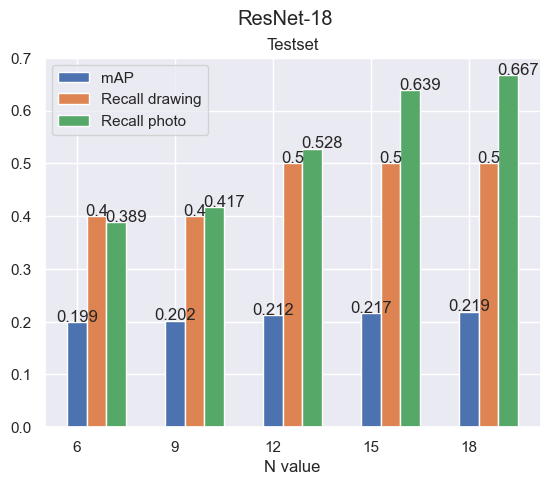

In [937]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

X = ['6', '9', '12', '15', '18']
# X = ['6', '12', '24', '48', '96']
Ymap = [0.199, 0.202, 0.212, 0.217, 0.219]
Yphoto = [0.389, 0.417, 0.528, 0.639, 0.667]
Ypc = [0.4, 0.4, 0.5, 0.5, 0.5]

X_axis = np.arange(len(X))
w = 1.0/(3 + 2)

plt.bar(X_axis, Ymap, w, label = 'mAP')
addlabel(X, Ymap, w=0)

plt.bar(X_axis+w, Ypc, w, label = 'Recall drawing')
addlabel(X, Ypc, w)

plt.bar(X_axis+w*2, Yphoto, w, label = 'Recall photo')
addlabel(X, Yphoto, 0.5)

plt.xticks(X_axis, X)
plt.xlabel("N value")

plt.suptitle("ResNet-18")
plt.title("Testset")

plt.legend()
plt.show()

## Domain expert results

In [ ]:
%%time
models = [('resnet18', 512, 'ResNet18')]
metrics = ["angular"]
a = '1.0'
n = 12

domain_results = create_results(models, metrics, comics_sample, n, trees_path, indexes_path, sep='_stylized_adain_sample_', expert = True)
domain_results

In [ ]:
# img = domain_results['resnet18']['angular']['comic_15.jpg']

def annotate_results(init_res):
    matches={}
    results = {}
    comics_count = []
    mps_count = []
    for model in init_res.keys():
        matches[model] = {}
        results[model] = {}
        for metric in init_res[model].keys():
            matches[model][metric] = {}
            results[model][metric] = {}
            for i, v in enumerate(init_res[model][metric]):
                print(str(i+1)+"/" + str(len(init_res[model][metric].keys())))
                display(init_res[model][metric][v][2].resize((512,512)))
                grid = image_grid(list(list(zip(*init_res[model][metric][v][0]))[0]), rows=3, cols=4)
                display(grid)
                
                correct = input('correct: ')
                comics_count.append(input('comics: '))
                mps_count.append(input('MPs: '))
                if correct == 'return':
                    comics_count = sum([eval(i) for i in comics_count])
                    mps_count = sum([eval(i) for i in mps_count])
                    
                    return (matches, results, comics_count, mps_count)
                try:
                    correct = map(int, correct.split())
                    matches[model][metric][v] = [init_res[model][metric][v][0][i-1][2] for i in correct if i < len(init_res[model][metric][v][1])]
                    results[model][metric][v] = init_res[model][metric][v][1]
                except:
                    continue
                    
                clear_output(wait=False)
        break
        
            
    comics_count = sum([eval(i) for i in comics_count])
    mps_count = sum([eval(i) for i in mps_count])
    
    return (matches, results, comics_count, mps_count)
        
domain_exp_results = annotate_results(domain_results)

In [ ]:
# domain_exp_results = Out[797]
# domain_exp_results[0]['resnet18']['angular']

In [878]:
comic_count = domain_exp_results[2]
mp_count = domain_exp_results[3]

IndexError: tuple index out of range

In [854]:
keys = []
values = []
for k, v in zip(domain_exp_results[0]['resnet18']['angular'].keys(), 
                domain_exp_results[0]['resnet18']['angular'].values()):
    keys.append(k)
    if v == []:
        values.append([np.nan])
    else:
        values.append(v)
matches_dict = {'comic': keys, 'correct': values}
domain_exp_matches = pd.DataFrame.from_dict(matches_dict)
domain_exp_matches = domain_exp_matches.set_index('comic')

In [855]:
domain_exp_matches

,correct
comic,
0a65a302aa8b4a8b8c56429a3cc83643.jpg,[nan]
0ad378af794f47b4a61fdeac548f1e49.jpg,[nan]
00bade79faf741c29cefcedfb29268e0.jpg,[d87f5f92ff194f00aa3dba78b27132cc.jpg]
0b48fa2bf8064d65b0825909ca45034f.jpg,[f86225da0d6c449098743ead63488ac6.jpg]
0a4d377a150a462385a3b016fe1e4f27.jpg,[nan]
...,...
0a6a7164b5e443fa9da9d1aa7eedb329.jpg,[nan]
0a37f7b7f9c340bc826531ec1a2032cc.jpg,[nan]
0b75417d7af142e6ad7d85a92ed4f187.jpg,[nan]


In [856]:
calculate_model_accuracy(domain_exp_results[1], domain_exp_matches)

{'accuracy': {'resnet18': {'angular': 0.15920398009950248}},
 'recall': {'resnet18': {'angular': {'pc': 0.1, 'photo': 0.0}}},
 'map': {'resnet18': {'angular': 0.06141981291235023}}}

In [877]:
value_list = []
for v in domain_exp_results[1]['resnet18']['angular'].values():
    value_list += v
distinct = len(set(value_list))
print(distinct)
count_dict = Counter(value_list)

unique = list(count_dict.values()).count(1)
print(unique)

388
186


# Notes

### OLD

In [ ]:
# class Evaluation():
#     def __init__(self, method_str = None):
#         if method_str != None and method_str.lower() == 'manhattan':
#             method_str = 'cityblock'
#         self.dist_method = method_str if method_str is not None else 'euclidean'
    
#     def tensor_to_array(self, ten):
#         arr = ten.squeeze(0).detach().numpy().flatten()
#         # arr = [v.flatten() for v in arr]
#         return np.array([arr])
    
#     def distance(self, vec1, vec2):
#         return distance.cdist(vec1, vec2, self.dist_method)[0][0]

In [ ]:
# grid = image_grid(list(list(zip(*en2_img))[0]), rows=2, cols=3)
# grid

In [ ]:
# %%time
# models = [('resnet18', 512, 'ResNet18'), ('vgg16', 512, 'VGG16'), 
#           ('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]
# dm = ["angular", "euclidean", "manhattan", "hamming",  "dot"]

# for m in models:
#     w = m[2]+'_Weights.DEFAULT'
#     model = Model(m[0], [3, 256, 256], weights=w)
#     model.feature_extractor('avgpool', 'avgpool')
    
#     photos_embedded_conv = model.embed(photos_conv)
#     pcs_embedded_conv = model.embed(pcs_conv)
    
#     if m[0] != 'vgg16':
#         photos_embedded_conv_flat = [(photo[0].squeeze(0).detach().numpy().flatten(), photo[1], photo[2], photo[3]) for photo in photos_embedded_conv]
#         pcs_embedded_conv_flat = [(pc[0].squeeze(0).detach().numpy().flatten(), pc[1], pc[2], pc[3]) for pc in pcs_embedded_conv]
#     else:
#         photos_embedded_conv_flat = [(mean_vgg16(photo[0]), photo[1], photo[2], photo[3]) for photo in photos_embedded_conv]
#         pcs_embedded_conv_flat = [(mean_vgg16(pc[0]), pc[1], pc[2], pc[3]) for pc in pcs_embedded_conv]
        
#     for d in dm:
#         if d == 'dot':
#             photos_embedded_conv_flat = [(preprocessing.normalize([photo[0]], norm='l2').flatten(), photo[1], photo[2], photo[3]) for photo in photos_embedded_conv_flat]
#             pcs_embedded_conv_flat = [(preprocessing.normalize([pc[0]], norm='l2').flatten(), pc[1], pc[2], pc[3]) for pc in pcs_embedded_conv_flat]
#         tree = Tree(m[1], d)
#         tree.buildTree([photos_embedded_conv_flat, pcs_embedded_conv_flat], m[0]+'_conv_'+d)

In [ ]:
# %%time
# models = [('resnet18', 512, 'ResNet18'), ('vgg16', 512, 'VGG16'), 
#           ('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]
# dm = ["angular", "euclidean", "manhattan", "hamming",  "dot"]

# for m in models:
#     w = m[2]+'_Weights.DEFAULT'
#     model = Model(m[0], [3, 256, 256], weights=w)
#     model.feature_extractor('avgpool', 'avgpool')
    
#     photos_embedded_stylized = model.embed(photos_stylized)
#     pcs_embedded = model.embed(pcs)
    
#     if m[0] != 'vgg16':
#         photos_embedded_stylized_flat = [(photo[0].squeeze(0).detach().numpy().flatten(), photo[1], photo[2], photo[3]) for photo in photos_embedded_stylized]
#         pcs_embedded_flat = [(pc[0].squeeze(0).detach().numpy().flatten(), pc[1], pc[2], pc[3]) for pc in pcs_embedded]
#     else:
#         photos_embedded_stylized_flat = [(mean_vgg16(photo[0]), photo[1], photo[2], photo[3]) for photo in photos_embedded_stylized]
#         pcs_embedded_flat = [(mean_vgg16(pc[0]), pc[1], pc[2], pc[3]) for pc in pcs_embedded]
        
#     for d in dm:
#         if d == 'dot':
#             photos_embedded_stylized_flat = [(preprocessing.normalize([photo[0]], norm='l2').flatten(), photo[1], photo[2], photo[3]) for photo in photos_embedded_stylized_flat]
#             pcs_embedded_flat = [(preprocessing.normalize([pc[0]], norm='l2').flatten(), pc[1], pc[2], pc[3]) for pc in pcs_embedded_flat]
#         tree = Tree(m[1], d)
#         tree.buildTree([photos_embedded_stylized_flat, pcs_embedded_flat], m[0]+'_stylized_'+d)

In [ ]:
# %%time
# models = [('resnet18', 512, 'ResNet18'), ('vgg16', 512, 'VGG16'), 
#           ('efficientnet_v2_s', 1280, 'EfficientNet_V2_S')]
# dm = ["angular", "euclidean", "manhattan", "hamming",  "dot"]

# for m in models:
#     w = m[2]+'_Weights.DEFAULT'
#     model = Model(m[0], [3, 256, 256], weights=w)
#     model.feature_extractor('avgpool', 'avgpool')
    
#     photos_embedded = model.embed(photos)
#     pcs_embedded = model.embed(pcs)
    
#     if m[0] != 'vgg16':
#         photos_embedded_flat = [(photo[0].squeeze(0).detach().numpy().flatten(), photo[1], photo[2], photo[3]) for photo in photos_embedded]
#         pcs_embedded_flat = [(pc[0].squeeze(0).detach().numpy().flatten(), pc[1], pc[2], pc[3]) for pc in pcs_embedded]
#     else:
#         photos_embedded_flat = [(mean_vgg16(photo[0]), photo[1], photo[2], photo[3]) for photo in photos_embedded]
#         pcs_embedded_flat = [(mean_vgg16(pc[0]), pc[1], pc[2], pc[3]) for pc in pcs_embedded]
        
#     for d in dm:
#         if d == 'dot':
#             photos_embedded_flat = [(preprocessing.normalize([photo[0]], norm='l2').flatten(), photo[1], photo[2], photo[3]) for photo in photos_embedded_flat]
#             pcs_embedded_flat = [(preprocessing.normalize([pc[0]], norm='l2').flatten(), pc[1], pc[2], pc[3]) for pc in pcs_embedded_flat]
#         tree = Tree(m[1], d)
#         tree.buildTree([photos_embedded_flat, pcs_embedded_flat], m[0]+'_'+d)

In [ ]:
# %%time
# '''
# ResNet-18 model
# '''
# res_model = Model('resnet18', [3, 256, 256], weights = 'ResNet18_Weights.DEFAULT')
# res_model.feature_extractor('avgpool', 'avgpool')

# # Regular embedding
# res_comics_embedded = res_model.embed(comics)
# res_comics_embedded = [(comic[0].squeeze(0).detach().numpy().flatten(), comic[1], comic[2], comic[3]) for comic in res_comics_embedded]

# # Convolved embedding
# res_comics_embedded_conv = res_model.embed(comics_conv)
# res_comics_embedded_conv = [(comic[0].squeeze(0).detach().numpy().flatten(), comic[1], comic[2], comic[3]) for comic in res_comics_embedded_conv]

In [ ]:
# '''
# VGG-16 model
# '''
# vgg_model = Model('vgg16', [3, 256, 256], weights = 'VGG16_Weights.DEFAULT')
# vgg_model.feature_extractor('avgpool', 'avgpool')
# t = Transform().transformer

# # Regular embedding
# vgg_comics_embedded = vgg_model.embed(comics)
# vgg_comics_embedded = [(mean_vgg16(comic[0]), comic[1], comic[2], comic[3]) for comic in vgg_comics_embedded]

# # Convolved embedding
# vgg_comics_embedded_conv = vgg_model.embed(comics_conv)
# vgg_comics_embedded_conv = [(mean_vgg16(comic[0]), comic[1], comic[2], comic[3]) for comic in vgg_comics_embedded_conv]

In [ ]:
# '''
# EfficentNetV2 model
# '''
# en2_model = Model('efficientnet_v2_s', [3, 256, 256], weights = 'EfficientNet_V2_S_Weights.DEFAULT')
# en2_model.feature_extractor('avgpool', 'avgpool')

# # Regular embedding
# en2_comics_embedded = en2_model.embed(comics)
# en2_comics_embedded = [(comic[0].squeeze(0).detach().numpy().flatten(), comic[1], comic[2], comic[3]) for comic in en2_comics_embedded]

# # Convolved embedding
# en2_comics_embedded_conv = en2_model.embed(comics_conv)
# en2_comics_embedded_conv = [(comic[0].squeeze(0).detach().numpy().flatten(), comic[1], comic[2], comic[3]) for comic in en2_comics_embedded_conv]